In [2]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install ipython-autotime

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.36 s


In [3]:
# GOAL: Dada la sinopsis de una película (texto), predecir todas los géneros a los que pertenece.
# "Text-to-label conversion"
#
# https://www.kaggle.com/cryptexcode/mpst-movie-plot-synopses-with-tags
# https://medium.com/towards-artificial-intelligence/keras-for-multi-label-text-classification-86d194311d0e

time: 1.26 ms


In [4]:
# Natural language toolkit, nos ayudara con preprocessing de los datos
import nltk
nltk.download('stopwords')

# Carga un set de stopwords predefinidas
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

# Imprime el set
print(STOPWORDS)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
{'about', 'themselves', 'all', "hasn't", 'too', 'an', 'in', "you're", 'does', 'having', 'been', 'himself', "shouldn't", 'or', 'has', 'while', 'if', 'doing', "wouldn't", 'ours', 'be', 'again', "haven't", 'below', 'how', 'more', 'weren', 'isn', "you'll", 'against', 'out', 'those', 'these', 'that', 'itself', 'once', 'will', 'didn', 'do', 'not', 'couldn', 'can', 'a', 'of', 'his', 'their', 'between', 'needn', 'did', 'but', 'herself', 'don', 'should', 'he', "you'd", "isn't", 'ma', 'you', 'theirs', 'each', 'its', "shan't", 'with', 'there', 'above', 'we', 'as', 'had', 'shouldn', "couldn't", 'my', "that'll", 'up', 'some', 'd', "you've", 'them', 'i', 'ain', 'after', 'what', 'until', 'than', 'further', 'were', 'doesn', 'to', "didn't", "hadn't", 've', "should've", "weren't", 'being', 'through', "wasn't", 'myself', "mightn't", 'wouldn', 'yourselves', 's', "mustn't", 'only', 'by', 'shan', '

# Part 1: Load and split data

In [5]:
# Requiered to select a file to be imported into colab
from google.colab import files
uploaded = files.upload()

Saving mpst_full_data.csv to mpst_full_data.csv
time: 5min 51s


In [6]:
# Load file from colab (G drive)
# Esto lo puedes modificar si lo estás corriendo localemente en vez de hacerlo en colab
df = pd.read_csv(r'mpst_full_data.csv', delimiter=',')
df.dropna(inplace=True)
df

,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb
...,...,...,...,...,...,...
14823,tt0219952,Lucky Numbers,"In 1988 Russ Richards (John Travolta), the wea...","comedy, murder",test,wikipedia
14824,tt1371159,Iron Man 2,"In Russia, the media covers Tony Stark's discl...","good versus evil, violence",train,wikipedia
14825,tt0063443,Play Dirty,During the North African Campaign in World War...,anti war,train,wikipedia
14826,tt0039464,High Wall,Steven Kenet catches his unfaithful wife in th...,murder,test,wikipedia


time: 750 ms


In [7]:
# Imprime un ejemplo de las sinopsis
df['plot_synopsis'][0]

'Note: this synopsis is for the orginal Italian release with the segments in this certain order.Boris Karloff introduces three horror tales of the macabre and the supernatural known as the \'Three Faces of Fear\'.THE TELEPHONERosy (Michele Mercier) is an attractive, high-priced Parisian call-girl who returns to her spacious, basement apartment after an evening out when she immediately gets beset by a series of strange phone calls. The caller soon identified himself as Frank, her ex-pimp who has recently escaped from prison. Rosy is terrified for it was her testimony that landed the man in jail. Looking for solace, Rosy phones her lesbian lover Mary (Lynda Alfonsi). The two women have been estranged for some time, but Rosy is certain that she is the only one who can help her. Mary agrees to come over that night. Seconds later, Frank calls again, promising that no matter who she calls for protection, he will have his revenge. Unknown to Rosy, Mary is the caller impersonating Frank. Marry

time: 4.85 ms


In [8]:
# Checking for NaN values.
print("checking if any null values are present\n", df.isna().sum())

checking if any null values are present
 imdb_id            0
title              0
plot_synopsis      0
tags               0
split              0
synopsis_source    0
dtype: int64
time: 9.83 ms


In [9]:
# Split data: train, val, and test
df_x_train = df.loc[df['split'] == 'train', 'plot_synopsis']
df_x_val   = df.loc[df['split'] == 'val', 'plot_synopsis']
df_x_test  = df.loc[df['split'] == 'test', 'plot_synopsis']

df_y_train = df.loc[df['split'] == 'train', 'tags']
df_y_val   = df.loc[df['split'] == 'val', 'tags']
df_y_test  = df.loc[df['split'] == 'test', 'tags']

print(df_x_train.shape)
print(df_x_val.shape)
print(df_x_test.shape)
print(df_y_train.shape)
print(df_y_val.shape)
print(df_y_test.shape)

(9489,)
(2373,)
(2966,)
(9489,)
(2373,)
(2966,)
time: 25.3 ms


In [10]:
print(df_y_train[0])
print(df_x_train[0])

cult, horror, gothic, murder, atmospheric
Note: this synopsis is for the orginal Italian release with the segments in this certain order.Boris Karloff introduces three horror tales of the macabre and the supernatural known as the 'Three Faces of Fear'.THE TELEPHONERosy (Michele Mercier) is an attractive, high-priced Parisian call-girl who returns to her spacious, basement apartment after an evening out when she immediately gets beset by a series of strange phone calls. The caller soon identified himself as Frank, her ex-pimp who has recently escaped from prison. Rosy is terrified for it was her testimony that landed the man in jail. Looking for solace, Rosy phones her lesbian lover Mary (Lynda Alfonsi). The two women have been estranged for some time, but Rosy is certain that she is the only one who can help her. Mary agrees to come over that night. Seconds later, Frank calls again, promising that no matter who she calls for protection, he will have his revenge. Unknown to Rosy, Mary i

# Part 2: Format data accordingly

In [11]:
# Aux funcción para substituir abreciacioes
import re
def decontracted(phrase):
  phrase = re.sub(r"won't", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase

time: 6.66 ms


In [12]:
# Set adicional de stopwords, removeremos palabras tanto de este set como del que
# viene definido en el nltk
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

time: 5.27 ms


In [13]:
# Función auxiliar para remover stopwords y otras normalizaciones de texto
# (Aqui puedes incluir el lematizador o stemming si gustas explorarlos)
def remove_stopwords(dataframe):
  SYNS = []
  for sentance in dataframe:
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in STOPWORDS)
    SYNS.append(sentance.strip())
  return SYNS

time: 4.41 ms


In [14]:
# Remueve stopwords
synops_train = remove_stopwords(df_x_train)
synops_val   = remove_stopwords(df_x_val)
synops_test  = remove_stopwords(df_x_test)

time: 16.4 s


In [15]:
synops_train[:10]

['note synopsis orginal italian release segments certain order boris karloff introduces three horror tales macabre supernatural known three faces fear telephonerosy michele mercier attractive high priced parisian call girl returns spacious basement apartment evening immediately gets beset series strange phone calls caller soon identified frank ex pimp recently escaped prison rosy terrified testimony landed man jail looking solace rosy phones lesbian lover mary lynda alfonsi two women estranged time rosy certain one help mary agrees come night seconds later frank calls promising matter calls protection revenge unknown rosy mary caller impersonating frank marry arrives rosy apartment soon best calm rosy nerves gives panic struck woman tranquillizer puts bed later night rosy sleeps mary gets bed pens note confession one making strange phone calls learned franks escape prison knowing rosy would call help explains felt way coming back life breakup busy writing fails notice intruder apartmen

time: 3.98 ms


In [87]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Entrena un Tokenizer
# Crea un diccionario numerado de las palabras existentes en el corpus, y devuelve
# por cada palabra, el número entero de su índice en el diccionario.
# En este caso, considera las 2000 palabras más frecuentes.
# oov_token = constante asiganda para palabras fuera del vocabulario
tokenizer = Tokenizer(num_words=2000, oov_token='<OOV>')
tokenizer.fit_on_texts(synops_train)

print("Number of words in the dictionary", len(tokenizer.word_index))
print(list(tokenizer.word_index.items())[:10])

Number of words in the dictionary 98801
[('<OOV>', 1), ('tells', 2), ('one', 3), ('back', 4), ('man', 5), ('two', 6), ('get', 7), ('house', 8), ('time', 9), ('go', 10)]
time: 2.97 s


In [88]:
# Convierte palabras en enteros
train_sequences = tokenizer.texts_to_sequences(synops_train)
lengths = []
for seq in train_sequences:
  lengths.append(len(seq))

print("Shortest article with", np.array(lengths).min(), "words.")
print("Longest article with", np.array(lengths).max(), "words.")
print(f"Average length: {np.array(lengths).mean():.2f} +- {np.array(lengths).std():.2f} words.")
print('\n')

for seq in train_sequences[:10]:
  print(seq)

Shortest article with 45 words.
Longest article with 5826 words.
Average length: 484.99 +- 455.22 words.


[679, 1, 1, 1, 1042, 1, 1673, 194, 1, 1, 909, 65, 1349, 1, 1, 1, 445, 65, 1, 823, 1, 1, 1, 1, 251, 1, 1, 154, 93, 74, 1, 797, 144, 474, 298, 32, 1, 524, 599, 165, 97, 1, 80, 1, 157, 744, 1, 1191, 1374, 297, 1, 1, 1, 1, 5, 821, 185, 1, 1, 1, 1, 1059, 232, 1, 1, 6, 264, 1, 9, 1, 1673, 3, 40, 232, 181, 76, 28, 1812, 16, 157, 97, 1, 1313, 97, 1, 541, 1029, 1, 232, 1, 1, 157, 438, 67, 1, 144, 80, 336, 1, 1, 1, 78, 1680, 1, 54, 1, 382, 252, 16, 28, 1, 1, 232, 32, 252, 1, 679, 1, 3, 249, 599, 165, 97, 1632, 1, 86, 297, 580, 1, 45, 154, 40, 138, 1, 41, 423, 4, 35, 1, 1, 1406, 1030, 1339, 1, 144, 9, 157, 230, 1, 109, 232, 1, 46, 3, 1, 1, 1, 1064, 1394, 1, 1, 1, 1, 1, 1, 152, 47, 724, 54, 839, 87, 41, 1, 252, 36, 340, 28, 1, 1440, 1, 499, 1, 232, 1, 1, 1, 499, 989, 157, 944, 1, 1, 745, 499, 266, 1, 1873, 6, 1, 280, 1, 1, 1, 1, 1, 1, 59, 1, 166, 670, 893, 1215, 18, 1, 1046, 499, 1, 387, 1, 1

In [89]:
# Hace todos los artículos del mismo tamaño usando padding y truncando
# Usaré maxlen = 500 (aprox) average length
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(train_sequences, maxlen=500, padding='pre', truncating='post')
lengths = []
for seq in x_train:
  lengths.append(len(seq))

print("Shortest article with", np.array(lengths).min(), "words.")
print("Longest article with", np.array(lengths).max(), "words.")
print("Average length:", np.array(lengths).mean(), "words.")
print('\n')

print((train_sequences[0]))
print((x_train[0]))

print((train_sequences[1]))
print((x_train[1]))

print((train_sequences[10]))
print((x_train[10]))

print('\n Max word index:', x_train.max())

Shortest article with 500 words.
Longest article with 500 words.
Average length: 500.0 words.


[679, 1, 1, 1, 1042, 1, 1673, 194, 1, 1, 909, 65, 1349, 1, 1, 1, 445, 65, 1, 823, 1, 1, 1, 1, 251, 1, 1, 154, 93, 74, 1, 797, 144, 474, 298, 32, 1, 524, 599, 165, 97, 1, 80, 1, 157, 744, 1, 1191, 1374, 297, 1, 1, 1, 1, 5, 821, 185, 1, 1, 1, 1, 1059, 232, 1, 1, 6, 264, 1, 9, 1, 1673, 3, 40, 232, 181, 76, 28, 1812, 16, 157, 97, 1, 1313, 97, 1, 541, 1029, 1, 232, 1, 1, 157, 438, 67, 1, 144, 80, 336, 1, 1, 1, 78, 1680, 1, 54, 1, 382, 252, 16, 28, 1, 1, 232, 32, 252, 1, 679, 1, 3, 249, 599, 165, 97, 1632, 1, 86, 297, 580, 1, 45, 154, 40, 138, 1, 41, 423, 4, 35, 1, 1, 1406, 1030, 1339, 1, 144, 9, 157, 230, 1, 109, 232, 1, 46, 3, 1, 1, 1, 1064, 1394, 1, 1, 1, 1, 1, 1, 152, 47, 724, 54, 839, 87, 41, 1, 252, 36, 340, 28, 1, 1440, 1, 499, 1, 232, 1, 1, 1, 499, 989, 157, 944, 1, 1, 745, 499, 266, 1, 1873, 6, 1, 280, 1, 1, 1, 1, 1, 1, 59, 1, 166, 670, 893, 1215, 18, 1, 1046, 499, 1, 387, 1, 1564, 22, 1,

In [90]:
# También para datos de val y test
val_sequences = tokenizer.texts_to_sequences(synops_val)
x_val = pad_sequences(val_sequences, maxlen=500, padding='pre', truncating='post')

test_sequences = tokenizer.texts_to_sequences(synops_test)
x_test = pad_sequences(test_sequences, maxlen=500, padding='pre', truncating='post')

time: 1.47 s


In [91]:
# Ahora cambiemos las etiquetas
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(df['tags']) # Entrena un Tokenizer para etiquetas

print("Number of words in the dictionary", len(label_tokenizer.word_index))
print(list(label_tokenizer.word_index.items()))

Number of words in the dictionary 82
[('murder', 1), ('violence', 2), ('flashback', 3), ('romantic', 4), ('cult', 5), ('revenge', 6), ('comedy', 7), ('psychedelic', 8), ('suspenseful', 9), ('good', 10), ('versus', 11), ('evil', 12), ('humor', 13), ('satire', 14), ('entertaining', 15), ('neo', 16), ('noir', 17), ('action', 18), ('sadist', 19), ('insanity', 20), ('tragedy', 21), ('fantasy', 22), ('paranormal', 23), ('boring', 24), ('mystery', 25), ('horror', 26), ('melodrama', 27), ('cruelty', 28), ('gothic', 29), ('historical', 30), ('dramatic', 31), ('dark', 32), ('atmospheric', 33), ('storytelling', 34), ('sci', 35), ('fi', 36), ('alternate', 37), ('psychological', 38), ('absurd', 39), ('realism', 40), ('prank', 41), ('sentimental', 42), ('philosophical', 43), ('avant', 44), ('garde', 45), ('bleak', 46), ('depressing', 47), ('plot', 48), ('twist', 49), ('reality', 50), ('cute', 51), ('stupid', 52), ('fiction', 53), ('intrigue', 54), ('pornographic', 55), ('home', 56), ('movie', 57), (

In [92]:
# Usa el Tokenizer y convierte las etiquetas a formato de enteros
y_train_int = np.array(label_tokenizer.texts_to_sequences(df_y_train))
y_val_int   = np.array(label_tokenizer.texts_to_sequences(df_y_val))
y_test_int  = np.array(label_tokenizer.texts_to_sequences(df_y_test))

print("y train:")
print(y_train_int[0])
print(y_train_int[1])
print(y_train_int[2])
print(y_train_int.shape)

print("y val:")
print(y_val_int[0])
print(y_val_int[1])
print(y_val_int[2])
print(y_val_int.shape)

print("y test:")
print(y_test_int[0])
print(y_test_int[1])
print(y_test_int[2])
print(y_test_int.shape)

y train:
[5, 26, 29, 1, 33]
[2]
[63, 4, 52, 74, 10]
(9489,)
y val:
[28, 1, 31, 5, 2, 33, 18, 4, 6, 19]
[4, 70, 3]
[3]
(2373,)
y test:
[4]
[10, 11, 12]
[23, 26, 58]
(2966,)
time: 199 ms


In [93]:
# AUX function to put a list of integer into binary vector form
def int2binary(LABELS, num_classes):
  y = np.zeros((len(LABELS), num_classes))

  for ind_lab, labels in enumerate(LABELS):
    for label in labels:
      y[ind_lab, label-1] = 1
      
  return y

time: 4.25 ms


In [94]:
# Convert labels into binary vector form
# (We know there are 82 different classes)
y_train = int2binary(y_train_int, 82)
y_val = int2binary(y_val_int, 82)
y_test = int2binary(y_test_int, 82)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(9489, 82)
(2373, 82)
(2966, 82)
time: 22.2 ms


# Part 3: Create LSTM

In [95]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

time: 3.64 ms


In [96]:
# Crea una red con layers Embedding, LSTM, Dense
model = Sequential()
#model.add(Embedding(input_dim=2000, output_dim=16))
model.add(Embedding(input_dim=2000, output_dim=16))
model.add(LSTM(units=16, return_sequences=True))
model.add(LSTM(units=32))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=82, activation='sigmoid'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 16)          32000     
_________________________________________________________________
lstm_20 (LSTM)               (None, None, 16)          2112      
_________________________________________________________________
lstm_21 (LSTM)               (None, 32)                6272      
_________________________________________________________________
dense_20 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_21 (Dense)             (None, 82)                5330      
Total params: 47,826
Trainable params: 47,826
Non-trainable params: 0
_________________________________________________________________
time: 389 ms


In [97]:
# Compile
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

time: 54.2 ms


In [98]:
# Train it
history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_val, y_val))

Train on 9489 samples, validate on 2373 samples
Epoch 1/10
9489/9489 [==============================] - 117s 12ms/sample - loss: 0.2589 - acc: 0.9455 - val_loss: 0.1374 - val_acc: 0.9596
Epoch 2/10
9489/9489 [==============================] - 114s 12ms/sample - loss: 0.1355 - acc: 0.9604 - val_loss: 0.1373 - val_acc: 0.9596
Epoch 3/10
9489/9489 [==============================] - 113s 12ms/sample - loss: 0.1355 - acc: 0.9604 - val_loss: 0.1374 - val_acc: 0.9596
Epoch 4/10
9489/9489 [==============================] - 115s 12ms/sample - loss: 0.1355 - acc: 0.9604 - val_loss: 0.1375 - val_acc: 0.9596
Epoch 5/10
9489/9489 [==============================] - 118s 12ms/sample - loss: 0.1355 - acc: 0.9604 - val_loss: 0.1375 - val_acc: 0.9596
Epoch 6/10
9489/9489 [==============================] - 117s 12ms/sample - loss: 0.1355 - acc: 0.9604 - val_loss: 0.1374 - val_acc: 0.9596
Epoch 7/10
9489/9489 [==============================] - 115s 12ms/sample - loss: 0.1353 - acc: 0.9604 - val_loss: 0.13

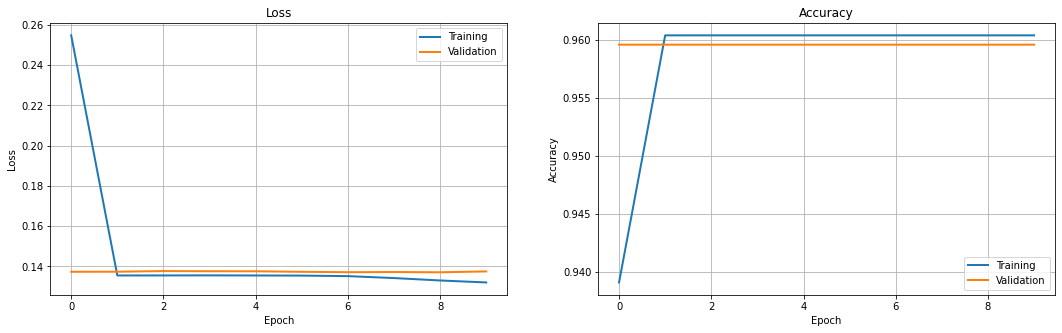

time: 362 ms


In [32]:
# Plot loss
plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['acc'], label='Training', linewidth=2)
plt.plot(history.history['val_acc'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

In [99]:
# Predict on test set
y_test_hat = model.predict(x_test)

print("Test ground-truth:")
print(y_test[:5])
print("\n Test prediction:")
print(y_test_hat[:5].round())

Test ground-truth:
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [105]:
from tensorflow.keras.layers import Flatten, GRU

#model = Sequential()
#model.add(Embedding(input_dim=2000, output_dim=16))
#model.add(LSTM(units=16, return_sequences=True))
#model.add(LSTM(units=32))
#model.add(Dense(units=64, activation='relu'))
#model.add(Dense(units=82, activation='sigmoid'))

model = Sequential()
model.add(Embedding(input_dim=2000, output_dim=16))
model.add(GRU(units=16, return_sequences=True))
model.add(GRU(units=32))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=82, activation='sigmoid'))

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 16)          32000     
_________________________________________________________________
gru_3 (GRU)                  (None, None, 16)          1584      
_________________________________________________________________
gru_4 (GRU)                  (None, 32)                4704      
_________________________________________________________________
dense_24 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_25 (Dense)             (None, 82)                5330      
Total params: 45,730
Trainable params: 45,730
Non-trainable params: 0
_________________________________________________________________
time: 407 ms


In [106]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

time: 52.3 ms


In [107]:
history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_val, y_val))

Train on 9489 samples, validate on 2373 samples
Epoch 1/10
9489/9489 [==============================] - 101s 11ms/sample - loss: 0.2626 - acc: 0.9416 - val_loss: 0.1374 - val_acc: 0.9596
Epoch 2/10
9489/9489 [==============================] - 99s 10ms/sample - loss: 0.1355 - acc: 0.9604 - val_loss: 0.1377 - val_acc: 0.9596
Epoch 3/10
9489/9489 [==============================] - 99s 10ms/sample - loss: 0.1355 - acc: 0.9604 - val_loss: 0.1373 - val_acc: 0.9596
Epoch 4/10
9489/9489 [==============================] - 101s 11ms/sample - loss: 0.1354 - acc: 0.9604 - val_loss: 0.1374 - val_acc: 0.9596
Epoch 5/10
9489/9489 [==============================] - 102s 11ms/sample - loss: 0.1348 - acc: 0.9604 - val_loss: 0.1374 - val_acc: 0.9596
Epoch 6/10
9489/9489 [==============================] - 100s 11ms/sample - loss: 0.1335 - acc: 0.9604 - val_loss: 0.1379 - val_acc: 0.9596
Epoch 7/10
9489/9489 [==============================] - 100s 11ms/sample - loss: 0.1326 - acc: 0.9604 - val_loss: 0.1380

In [0]:
# == Q1 ==
# A pesar de tener muy buena exactitud, la pérdida no bajó de 0.13, y más aún,
# la salida de la celda anterior muestra que se equivocó al pronosticar las clases positivas,
# incluso en el set de entrenamiento. ¿Por qué crees que eso sucede?

#Pensábamos que podía ser por el número de palabras del vocabulario. Sin embargo, probamos con un vocabulario de 6,000 palabras 
#y con otro de 9,000 y no cambiaron mucho los resultados.

# == Q2 ==
# ¿Por qué crees que este modelo toma mucho más tiempo para entrenarse, en comparación
# con los modelos que habíamos entrenado anteriormente?

# == Q3 ==
# ¿Recuerdas cómo funciona el layer Embedding? ¿Qué significan los parámetros de
# entrada y salida?

#Toma vectores en los que las palabras se representan como enteros y los transforma a vectores de una dimensión dada.

#model.add(Embedding(input_dim=2000, output_dim=16)) significa que el vocabulario es de tamaño 2000 y el vector de salida es 
#de tamaño 16.

# == Q4 ==
# Diseña y entrena un modelo que minimice la pérdida hasta 0.05 o menos.
# Además de jugar con los parámetros que ya conocemos, como el número de layers,
# el número de parámetros en cada layer, loss, optimizer, etc., si quieres
# también explora otros valores para el número de palabras totales en el diccionario
# (definidas en el Tokenizer) y los argumentos para el padding.

#Se probaron varios modelos, pero ninguno mejora mucho los resultados del modelo original. 
#Si se usa un vocabulario de 9,000 palabras, se alcanza una pérdida del orden de 12 punto algo, pero luego empieza a haber un ligero 
#sobreentrenamiento.

# == Q5 ==
# Investiga como instanciar GRU
# Compara RNN vs LSTM vs GRU. Reporta comparación en términos de número de parámetros,
# tiempo requerido para entrenamiento, y desempeño obtenido.

#Con GRU se obtienen resultados similares.
